<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-24 13:32:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0s      

2019-12-24 13:32:16 (157 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         156 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    ca-certificates-2019.11.27 |                0         132 KB  anaconda
    seaborn-0.9.0              |     pyh91ea838_1         164 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following packages will be UPDATED:

    ca-certificates: 2019.11.27-0       --> 2019.11.27-0       anaconda
    certifi:         2019.11.28-py36_0  --> 2019.11.28-py36_0  anaconda
    openssl:         1.1.1d-h7b6447c_3  --> 1.1.1-h7b6447c_0   anaconda
    seaborn:         0.9.0-py

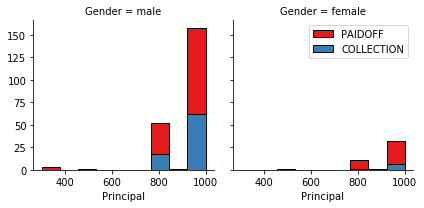

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

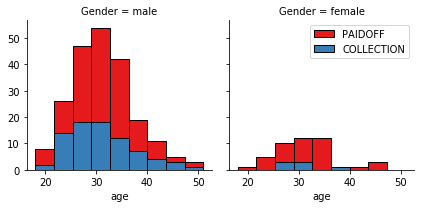

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

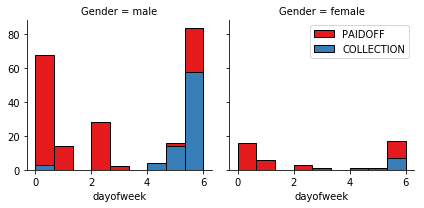

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [78]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print("X_train size is ", X_train.shape, "\n", "X_test size is ", X_test.shape, "\n",
      "y_train size is ", y_train.shape, "\n", "y_test size is ", y_test.shape)
print(X_train[0:5])
y_train[0:5]

X_train size is  (276, 8) 
 X_test size is  (70, 8) 
 y_train size is  (276,) 
 y_test size is  (70,)
[[ 0.51578458 -0.95911111  0.67333883 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.81902922 -0.42056004  0.82934003 -0.38170062
   1.13639374 -0.86968108]
 [ 0.51578458  0.92071769  0.01006414 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458 -0.95911111 -0.98484789 -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.48739188 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]]


array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [83]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [84]:
# also need to normalize the test and train dataset
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
X_train[0:5]
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))
X_test[0:5]

array([[ 0.33474248,  0.83916906, -0.19614926, -0.47756693,  0.74535599,
        -0.2773501 ,  1.26197963, -1.05887304],
       [-1.70282047, -0.9301633 , -0.19614926, -0.47756693,  0.74535599,
        -0.2773501 , -0.79240582,  0.94440028],
       [ 0.33474248, -0.9301633 , -0.04012144, -0.47756693, -1.34164079,
        -0.2773501 ,  1.26197963, -1.05887304],
       [ 0.33474248,  0.83916906, -1.13231619, -0.47756693, -1.34164079,
        -0.2773501 , -0.79240582,  0.94440028],
       [ 0.33474248,  0.83916906,  0.42796202, -0.47756693, -1.34164079,
        -0.2773501 , -0.79240582,  0.94440028]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

Test set Accuracy at k= 1 :  0.6714285714285714
Test set Accuracy at k= 2 :  0.6428571428571429
Test set Accuracy at k= 3 :  0.7285714285714285
Test set Accuracy at k= 4 :  0.6571428571428571
Test set Accuracy at k= 5 :  0.7142857142857143
Test set Accuracy at k= 6 :  0.6571428571428571
Test set Accuracy at k= 7 :  0.7428571428571429
Test set Accuracy at k= 8 :  0.7428571428571429
Test set Accuracy at k= 9 :  0.7142857142857143


Text(0, 0.5, 'Testing Accuracy')

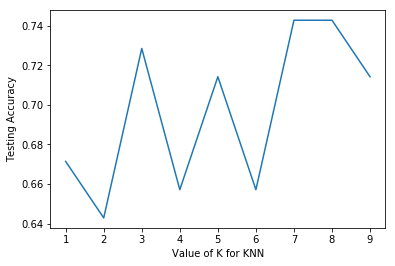

In [85]:
# finding a suitable k value
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_similarity_score
import matplotlib.pyplot as plt
%matplotlib inline

k_range = range(1, 10)
accuracy_score = []
for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    # perform the test
    knn_yhat = KNN.predict(X_test)
    print("Test set Accuracy at k=", k, ": ", jaccard_similarity_score(y_test, knn_yhat))
    accuracy_score.append(jaccard_similarity_score(y_test, knn_yhat))

# plot the relationship between K and testing accuracy
plt.plot(k_range, accuracy_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [86]:
# for KNN
from sklearn.neighbors import KNeighborsClassifier
# perform the test
KNN = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

# Decision Tree

In [87]:
# findinng the best depth level
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

# Compare accuracy result for depth = 3, 4 and 5
d_range = range(3, 6)
f1 = []
ja = []
for d in d_range:
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d)
    DT.fit(X_train, y_train)
    dt_yhat = DT.predict(X_test)
    f1.append(f1_score(y_test, dt_yhat, average='weighted'))
    ja.append(jaccard_similarity_score(y_test, dt_yhat))

result = pd.DataFrame(f1, index=['d=3','d=4', 'd=5'])
result.columns = ['F1-score']
result.insert(loc=1, column='Jacard', value=ja)
result.columns.name = "Depth"
result

Depth,F1-score,Jacard
d=3,0.620577,0.585714
d=4,0.620577,0.585714
d=5,0.648789,0.614286


In [88]:
# for Decision Trees
from sklearn.tree import DecisionTreeClassifier
# prepare DT setting
DT = DecisionTreeClassifier(criterion="entropy", max_depth=5)
# perform the test
DT.fit(X_train, y_train)
DT

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Support Vector Machine

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


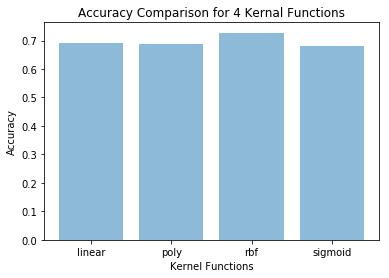

In [89]:
# for SVM
from sklearn import svm
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt
%matplotlib inline

func_list = ['linear', 'poly', 'rbf', 'sigmoid']
accuracy_score = []

for func in func_list:
    SVM = svm.SVC(kernel=func)
    SVM.fit(X_train, y_train)
    svm_yhat = SVM.predict(X_test)
    accuracy_score.append(f1_score(y_test, svm_yhat, average='weighted'))
    
# plot the comparison among 4 kernel functions
import numpy as np
import matplotlib.pyplot as plt
y_pos = np.arange(len(func_list))
plt.bar(y_pos, accuracy_score, align='center', alpha=0.5)
plt.xticks(y_pos, func_list)
plt.ylabel('Accuracy')
plt.xlabel('Kernel Functions')
plt.title('Accuracy Comparison for 4 Kernal Functions')
plt.show()

In [90]:
# for SVM
from sklearn import svm
# prepare SVM setting
SVM = svm.SVC(kernel='rbf')
# perform the test
SVM.fit(X_train, y_train)
SVM

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Logistic Regression

Test  0 : Accuracy at c = 0.1 solver= newton-cg is :  0.477460130698766
Test  1 : Accuracy at c = 0.1 solver= lbfgs is :  0.4774602624038005
Test  2 : Accuracy at c = 0.1 solver= liblinear is :  0.4909656081845792
Test  3 : Accuracy at c = 0.1 solver= sag is :  0.47745837151108433
Test  4 : Accuracy at c = 0.1 solver= saga is :  0.47746098501725365
Test  5 : Accuracy at c = 0.01 solver= newton-cg is :  0.4893356417828644
Test  6 : Accuracy at c = 0.01 solver= lbfgs is :  0.48933560490693945
Test  7 : Accuracy at c = 0.01 solver= liblinear is :  0.5699980927778155
Test  8 : Accuracy at c = 0.01 solver= sag is :  0.4893184067497661
Test  9 : Accuracy at c = 0.01 solver= saga is :  0.4893353843672382
Test  10 : Accuracy at c = 0.001 solver= newton-cg is :  0.5177257828275373
Test  11 : Accuracy at c = 0.001 solver= lbfgs is :  0.5177257382214536
Test  12 : Accuracy at c = 0.001 solver= liblinear is :  0.6691108543335518
Test  13 : Accuracy at c = 0.001 solver= sag is :  0.5177168329064271

Text(0, 0.5, 'Testing Accuracy')

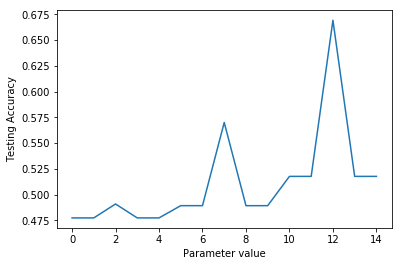

In [91]:
# for Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt
%matplotlib inline

c_list = [0.1, 0.01, 0.001]
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
idx = []

accuracy_score = []
for idx1, c in enumerate(c_list):
    for idx2, sol in enumerate(solver_list):
        idx.append(idx2 + idx1 * 5)
        # perform the test
        LR = LogisticRegression(C=c, solver=sol).fit(X_train, y_train)
        # it can predict the outcome
        lr_yhat = LR.predict(X_test)
        lr_prob = LR.predict_proba(X_test)
        print("Test ", (idx2 + idx1 * 5), ": Accuracy at c =", c,"solver=", sol,
              "is : ", log_loss(y_test, lr_prob))
        accuracy_score.append(log_loss(y_test, lr_prob))
lr_prob = LR.predict_proba(X_test)
log_loss(y_test, lr_prob)
# plot the relationship between K and testing accuracy
plt.plot(idx, accuracy_score)
plt.xlabel('Parameter value')
plt.ylabel('Testing Accuracy')

In [92]:
# for Logistic Regression
from sklearn.linear_model import LogisticRegression
# prepare LR setting
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train, y_train)
LR

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

First, download and load the test set:

In [93]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-24 14:04:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-24 14:04:01 (408 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [94]:
test_df = pd.read_csv('loan_test.csv')
# convert date time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
# evaulate weekend field
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# convert male to 0 and female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# work out education level
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
# Testing feature
X_loan_test = test_feature
# normalize the test data
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)
# and target result
y_loan_test = test_df['loan_status'].values
y_loan_test[0:5]
print (X_loan_test[0:5])
print (X_loan_test.shape)
print (y_loan_test[0:5])
print (y_loan_test.shape)

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]]
(54, 8)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
(54,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:17: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


# Evaluate Result

## Jaccard

In [95]:
# Jaccard setup
from sklearn.metrics import jaccard_similarity_score

# evaluate KNN
knn_yhat = KNN.predict(X_loan_test)
jc1 = round(jaccard_similarity_score(y_loan_test, knn_yhat), 2)
# evaluate Decision Trees
dt_yhat = DT.predict(X_loan_test)
jc2 = round(jaccard_similarity_score(y_loan_test, dt_yhat), 2)
#evaluate SVM
svm_yhat = SVM.predict(X_loan_test)
jc3 = round(jaccard_similarity_score(y_loan_test, svm_yhat), 2)
# evaluate Logistic Regression
lr_yhat = LR.predict(X_loan_test)
jc4 = round(jaccard_similarity_score(y_loan_test, lr_yhat), 2)

list_jc = [jc1, jc2, jc3, jc4]
list_jc

[0.67, 0.74, 0.8, 0.78]

## F1 Score 

In [96]:
# F1-score setup
from sklearn.metrics import f1_score

# evaluate KNN
fs1 = round(f1_score(y_loan_test, knn_yhat, average='weighted'), 2)
# evaluate Desision Trees 
fs2 = round(f1_score(y_loan_test, dt_yhat, average='weighted'), 2)
# evaluate SVM
fs3 = round(f1_score(y_loan_test, svm_yhat, average='weighted'), 2)
# evaluate Logistic Regression
fs4 = round(f1_score(y_loan_test, lr_yhat, average='weighted'),2 )

list_fs = [fs1, fs2, fs3, fs4]
list_fs

[0.63, 0.76, 0.76, 0.73]

## Log loss

In [97]:
# LogLoss
from sklearn.metrics import log_loss
lr_prob = LR.predict_proba(X_loan_test)
list_ll = ['NA', 'NA', 'NA', round(log_loss(y_loan_test, lr_prob), 2)]
list_ll

['NA', 'NA', 'NA', 0.67]

# Report

In [98]:
import pandas as pd

# fomulate the report format
df = pd.DataFrame(list_jc, index=['KNN','Decision Tree','SVM','Logistic Regression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
df.insert(loc=2, column='LogLoss', value=list_ll)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.67,0.63,NA
Decision Tree,0.74,0.76,NA
SVM,0.80,0.76,NA
Logistic Regression,0.78,0.73,0.67


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>